# Deep Learning Fundamentals Assignment 3
# Suhirtha Ravindran a1903155
# RNNs for stock price prediction

## Importing Libraries

In [1]:
import time
import math
import matplotlib.pyplot as plt
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
from sklearn.model_selection import GridSearchCV
import seaborn as sns

## 1. Loading Datasets

In [2]:
# Train data
train_df = pd.read_csv('Google_Stock_Price_Train.csv')
# Test data
test_df = pd.read_csv('Google_Stock_Price_Test.csv')

# Display train and test datasets
print("Train Data Sample:\n", train_df.head())
print("Test Data Sample:\n", test_df.head())

Train Data Sample:
        Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
Test Data Sample:
        Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400


## 1.1 Check data type and analysing dataset

In [3]:
print(type(train_df))
print(type(test_df))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [4]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB
None


In [5]:
print(f"Train set shape (raw, unprocessed): {train_df.shape}")
print(f"Test set shape (raw, unprocessed): {test_df.shape}")

Train set shape (raw, unprocessed): (1258, 6)
Test set shape (raw, unprocessed): (20, 6)


## 2. Preprocess the dataset and Validation split

In [6]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']
window = 20  # Number of past days or SEQ_LENGTH 
pred_output = 1  # Predicting the next day's price

In [7]:
# Remove formatting like commas from numerical columns
for col in ['Close', 'Volume']:
    for i in range(len(train_df[col])):
        if type(train_df[col][i])==str:
            train_df[col][i]= float(train_df[col][i].replace(',', ''))
    for i in range(len(test_df[col])):
        if type(test_df[col][i])==str:
            test_df[col][i] = float(test_df[col][i].replace(',', ''))

/var/folders/r_/jnt26c411jd375_pfnsg4m180000gn/T/ipykernel_63097/3138788586.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col][i]= float(train_df[col][i].replace(',', ''))
/var/folders/r_/jnt26c411jd375_pfnsg4m180000gn/T/ipykernel_63097/3138788586.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[col][i] = float(test_df[col][i].replace(',', ''))


## 2.1 Handling unusual values

In [8]:
# Overwrite values by dividing by 'High' where the value is greater than 'High' in 'Close'
for col in ['Close']:
    train_df[col] = train_df.apply(lambda row: row[col]/2 if row[col] > row['High'] else row[col], axis=1)

# Display data
print(train_df.head())

       Date    Open    High     Low    Close      Volume
0  1/3/2012  325.25  332.83  324.97  331.795   7380500.0
1  1/4/2012  331.27  333.87  329.08  333.225   5749400.0
2  1/5/2012  329.83  330.75  326.89  328.605   6590300.0
3  1/6/2012  328.34  328.77  323.68  324.120   5405900.0
4  1/9/2012  322.04  322.29  309.46  310.380  11688800.0


## 2.2 Checking datatypes 

In [9]:
train_df['Close'] = pd.to_numeric(train_df['Close'], errors='coerce')
train_df['Volume'] = pd.to_numeric(train_df['Volume'], errors='coerce')
train_df.info() # Every numerical column is converted to float type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   float64
 5   Volume  1258 non-null   float64
dtypes: float64(5), object(1)
memory usage: 59.1+ KB


In [10]:
# Display data
train_df

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,331.795,7380500.0
1,1/4/2012,331.27,333.87,329.08,333.225,5749400.0
2,1/5/2012,329.83,330.75,326.89,328.605,6590300.0
3,1/6/2012,328.34,328.77,323.68,324.120,5405900.0
4,1/9/2012,322.04,322.29,309.46,310.380,11688800.0
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.910,623400.0
1254,12/27/2016,790.68,797.86,787.66,791.550,789100.0
1255,12/28/2016,793.70,794.23,783.20,785.050,1153800.0
1256,12/29/2016,783.33,785.93,778.92,782.790,744300.0


## 2.3 Preprocessing
(Based on workshop codes)

In [11]:
# Standard Scaler function
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    # Flatten the data for scaling
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    # Reshape back to original shape
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test, preprocessor

# Preprocess the stock data
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    
    for i in range(len(data) - sequence_length):
        result.append(data[i : i + sequence_length])
        
    result = np.array(result)
    row1 = round(0.8 * result.shape[0])
    row2 = round(0.9 * result.shape[0])
    train = result[: int(row1), :]
    
    # Apply standard scaler
    
    X_train_scaled, result, preprocessor = standard_scaler(train, result)
    
    X_train = X_train_scaled[:, : -1]
    y_train = X_train_scaled[:, -1][: ,-1]
    X_valid = result[int(row1) : int(row2), : -1]
    y_valid = result[int(row1):int(row2) :, -1][ : ,-1]
    X_test = result[int(row2) : , : -1]
    y_test = result[int(row2): :, -1][ : ,-1]
    
    # Reshape data
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return X_train, y_train, X_valid, y_valid, X_test, y_test, preprocessor

In [12]:
print(f"New train data:\n{train_df.head()}")
print(f"New test data:\n{test_df.head()}")

New train data:
       Date    Open    High     Low    Close      Volume
0  1/3/2012  325.25  332.83  324.97  331.795   7380500.0
1  1/4/2012  331.27  333.87  329.08  333.225   5749400.0
2  1/5/2012  329.83  330.75  326.89  328.605   6590300.0
3  1/6/2012  328.34  328.77  323.68  324.120   5405900.0
4  1/9/2012  322.04  322.29  309.46  310.380  11688800.0
New test data:
       Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1657300.0
1  1/4/2017  788.36  791.34  783.16  786.90  1073000.0
2  1/5/2017  786.08  794.48  785.02  794.02  1335200.0
3  1/6/2017  795.26  807.90  792.20  806.15  1640200.0
4  1/9/2017  806.40  809.97  802.83  806.65  1272400.0


## 2.4 Validation Split

In [13]:
# Ensuring that the Date column is handled separately
train_df['Date'] = pd.to_datetime(train_df['Date'])  # Convert 'Date' to datetime format if needed
test_df['Date'] = pd.to_datetime(test_df['Date'])  # Convert 'Date' to datetime format if needed

train_df = train_df.drop(columns=['Date'])  # Drop 'Date' column from train_df
test_df = test_df.drop(columns=['Date'])  # Drop 'Date' column from test_df

# Validation split
X_train, y_train, X_valid, y_valid, X_test, y_test, preprocessor = preprocess_data(train_df[:: -1], window)

## 3. Exploratory Data Analysis (EDA)
### with Data Visualisation

In [14]:
# Basic statistics for targets
print("\nTarget Statistics (y_train):")
print(f"Mean: {np.mean(y_train)}, Std: {np.std(y_train)}, Min: {np.min(y_train)}, Max: {np.max(y_train)}")

print("\nTarget Statistics (y_val):")
print(f"Mean: {np.mean(y_valid)}, Std: {np.std(y_valid)}, Min: {np.min(y_valid)}, Max: {np.max(y_valid)}")

print("\nTarget Statistics (y_test):")
print(f"Mean: {np.mean(y_test)}, Std: {np.std(y_test)}, Min: {np.min(y_test)}, Max: {np.max(y_test)}")



Target Statistics (y_train):
Mean: -2.870879740444849e-17, Std: 1.0, Min: -1.5071625495958123, Max: 11.632660553451172

Target Statistics (y_val):
Mean: 1.4014534599502029, Std: 1.7664434370854503, Min: -0.5560729261148121, Max: 12.628131717602912

Target Statistics (y_test):
Mean: 1.5009016440434717, Std: 1.463575507561966, Min: -0.0746690716964783, Max: 10.507497922875114


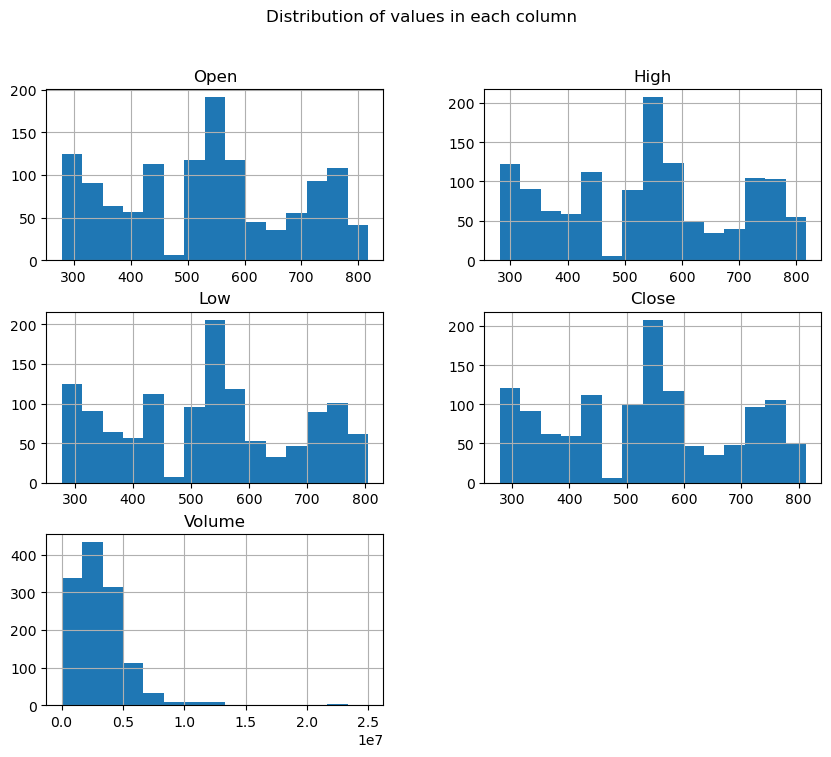

In [15]:
# Train Data
train_df.hist(bins=15, figsize=(10, 8))
plt.suptitle("Distribution of values in each column")
plt.show()

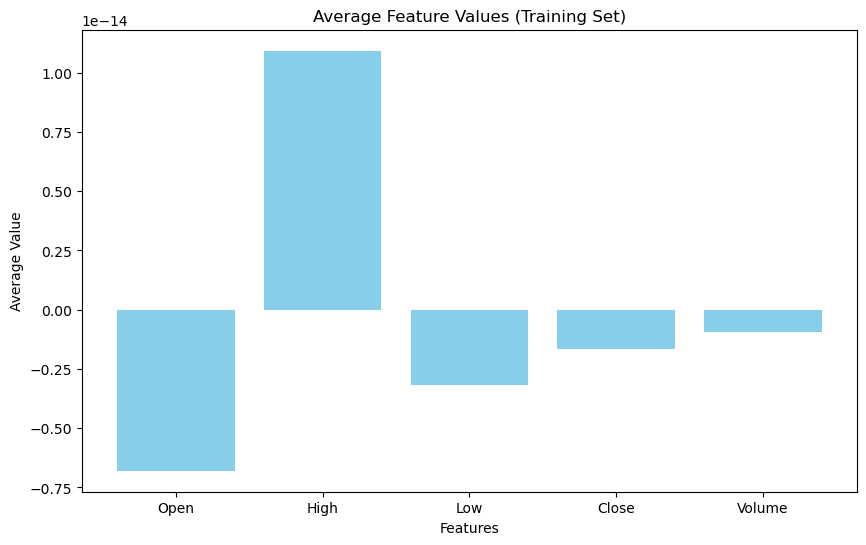

In [16]:
# Analysing input features
# Compute averages for each feature in X_train
feature_means = np.mean(X_train, axis=(0, 1))  # Average across samples and time steps
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Bar plot of feature averages
plt.figure(figsize=(10, 6))
plt.bar(features, feature_means, color='skyblue')
plt.title('Average Feature Values (Training Set)')
plt.ylabel('Average Value')
plt.xlabel('Features')
plt.show()


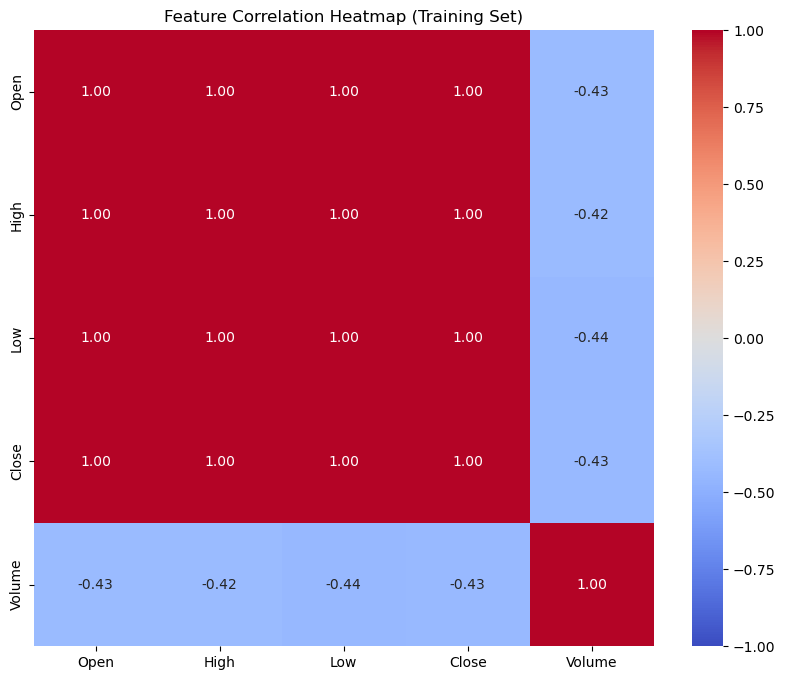

In [17]:
# Correlations between features
# Flatten X_train for correlation analysis
X_train_flat = X_train.reshape(-1, 5)  # Flatten to (samples * time_steps, features)
X_train_df = pd.DataFrame(X_train_flat, columns=features)

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X_train_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap (Training Set)')
plt.show()

## 4. Building and Training the models
Based on workshop codes

In [18]:
# Build the models

def LSTM_build_model(layers):
    model = Sequential()

    # Add LSTM layers
    model.add(LSTM(layers[1], return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(layers[2], return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(units=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model


def VRNN_build_model(layers):
    model = Sequential()

    model.add(SimpleRNN(layers[1], return_sequences=True, input_shape=(layers[0], layers[2])))
    model.add(Dropout(0.4))

    model.add(SimpleRNN(layers[2], return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(layers[3]))
    model.add(Activation("linear"))
    
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model


def GRU_build_model(layers):
    model = Sequential()
    
    model.add(GRU(layers[1], return_sequences=True, input_shape=(layers[0], layers[2])))
    model.add(Dropout(0.4))

    model.add(GRU(layers[2], return_sequences=False))
    model.add(Dropout(0.3))
    
    model.add(Dense(layers[3]))
    model.add(Activation("linear"))
    
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [19]:
# Checking the shapes
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_valid", X_valid.shape)
print("y_valid", y_valid.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (990, 20, 5)
y_train (990,)
X_valid (123, 20, 5)
y_valid (123,)
X_test (124, 20, 5)
y_test (124,)


In [20]:
# Train the models

lstm_model = LSTM_build_model([X_train.shape[2], window, 100, pred_output]) # [features, timesteps, units in GRU, output] # 20 days
gru_model = GRU_build_model([window, 100, X_train.shape[2], pred_output]) # [timesteps, units in GRU, features, output] # 20 days
vrnn_model = VRNN_build_model([window, 100, X_train.shape[2], pred_output]) # [timesteps, units in RNN, features, output] # 20 days

lstm_history = lstm_model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=30,
    validation_data=(X_valid, y_valid),
    verbose=1
)

gru_history = gru_model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=30,
    validation_data=(X_valid, y_valid),
    verbose=1
)

vrnn_history = vrnn_model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=30,
    validation_data=(X_valid, y_valid),
    verbose=1
)

Compilation Time :  0.0030808448791503906
Compilation Time :  0.0007560253143310547
Compilation Time :  0.0007300376892089844
Epoch 1/30


/Users/suhirtharavindran/Desktop/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.0000e+00 - loss: 0.8905 - val_accuracy: 0.0000e+00 - val_loss: 4.1540
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0000e+00 - loss: 0.8412 - val_accuracy: 0.0000e+00 - val_loss: 3.4465
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0000e+00 - loss: 0.6884 - val_accuracy: 0.0000e+00 - val_loss: 3.7250
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0000e+00 - loss: 0.7538 - val_accuracy: 0.0000e+00 - val_loss: 3.2276
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0000e+00 - loss: 0.6400 - val_accuracy: 0.0000e+00 - val_loss: 3.1124
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0000e+00 - loss: 0.6193 - val_accuracy: 0.0000e+00 - val_loss: 3.2429
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0000e+00 - loss: 0.7005 - val_accuracy: 0.0000e+00 - val_loss: 3.1035
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0000e+00 - loss:

Epoch 20/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0000e+00 - loss: 0.6348 - val_accuracy: 0.0000e+00 - val_loss: 2.9880
Epoch 21/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.0000e+00 - loss: 0.6136 - val_accuracy: 0.0000e+00 - val_loss: 2.9400
Epoch 22/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0000e+00 - loss: 0.5815 - val_accuracy: 0.0000e+00 - val_loss: 2.9211
Epoch 23/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.0000e+00 - loss: 0.5974 - val_accuracy: 0.0000e+00 - val_loss: 2.9517
Epoch 24/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.0000e+00 - loss: 0.5590 - val_accuracy: 0.0000e+00 - val_loss: 3.0125
Epoch 25/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.0000e+00 - loss: 0.6238 - val_accuracy: 0.0000e+00 - val_loss: 3.0499
Epoch 26/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0000e+00 - loss: 0.5828 - val_accuracy: 0.0000e+00 - val_loss: 2.9249
Epoch 27/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 

In [21]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 20)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 20)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,164 (395.18 KB)

 Trainable params: 50,581 (197.58 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,583 (197.59 KB)

In [22]:
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 20, 100)        │        32,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 5)              │         1,605 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,424 (263.38 KB)

 Trainable params: 33,711 (131.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,713 (131.70 KB)

In [23]:
vrnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20, 100)        │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 5)              │           530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,274 (87.01 KB)

 Trainable params: 11,136 (43.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,138 (43.51 KB)

## 4.1 Early Stopping and Hyperparameter tuning

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modify the model training to include early stopping
def train_model_with_early_stopping(model, X_train, y_train, X_valid, y_valid, batch_size, epochs):
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), verbose=1, callbacks=[early_stopping])
    return history

In [26]:
# LSTM

# Hyperparameter tuning using Grid Search
def tune_hyperparameters():
    param_grid = {
        'batch_size': [64, 128, 256],
        'epochs': [20, 30],
        'layers': [[X_train.shape[2], window, 100, pred_output], [X_train.shape[2], window, 200, pred_output]]  # Hyperparameter options for layers
    }

    best_score = float('inf')
    best_params = {}
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            for layers in param_grid['layers']:
                print(f"Training model with batch_size={batch_size}, epochs={epochs}, layers={layers}")
                lstm_model = LSTM_build_model(layers)
                history = train_model_with_early_stopping(lstm_model, X_train, y_train, X_valid, y_valid, batch_size, epochs)
                
                # Evaluating model on validation data
                val_loss = min(history.history['val_loss'])
                if val_loss < best_score:
                    best_score = val_loss
                    best_params = {'batch_size': batch_size, 'epochs': epochs, 'layers': layers}
                print(f"Validation Loss: {val_loss}")
    
    print("Best Hyperparameters: ", best_params)
    return best_params

# Finding best hyper parameters
best_params = tune_hyperparameters()

# Using the best hyper parameters to train the LSTM model
best_lstm_model = LSTM_build_model(best_params['layers'])
lstm_history = train_model_with_early_stopping(best_lstm_model, X_train, y_train, X_valid, y_valid, best_params['batch_size'], best_params['epochs'])

Training model with batch_size=64, epochs=20, layers=[5, 20, 100, 1]
Compilation Time :  0.0012202262878417969
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.7292 - val_accuracy: 0.0000e+00 - val_loss: 3.1149
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 1.0625 - val_accuracy: 0.0000e+00 - val_loss: 3.1538
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 0.6844 - val_accuracy: 0.0000e+00 - val_loss: 3.1497
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.5236 - val_accuracy: 0.0000e+00 - val_loss: 3.1887
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 0.6049 - val_accuracy: 0.0000e+00 - val_loss: 3.0610
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 0.5956 - val_accuracy: 0.0000e+00 - val_loss: 2.9854
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - los

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0000e+00 - loss: 0.5047 - val_accuracy: 0.0000e+00 - val_loss: 3.1542
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0000e+00 - loss: 0.6390 - val_accuracy: 0.0000e+00 - val_loss: 3.1864
Validation Loss: 3.0820579528808594
Training model with batch_size=128, epochs=30, layers=[5, 20, 100, 1]
Compilation Time :  0.0012958049774169922
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0000e+00 - loss: 0.8680 - val_accuracy: 0.0000e+00 - val_loss: 3.3321
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 0.6750 - val_accuracy: 0.0000e+00 - val_loss: 3.2275
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 0.5303 - val_accuracy: 0.0000e+00 - val_loss: 3.1285
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 0.5716 - val_accuracy: 0.0000e+00 - val_loss: 3.1838
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.00

In [27]:
# GRU

# Hyperparameter tuning using Grid Search
def tune_hyperparameters():
    # Define parameter grid for tuning
    param_grid = {
        'batch_size': [64, 128, 256],
        'epochs': [20, 30],
        'layers': [[window, 100, X_train.shape[2], pred_output],  # Corrected layers to be a list of lists
                   [window, 200, X_train.shape[2], pred_output]]  # Another example with different units
    }

    best_score = float('inf')
    best_params = {}
    
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            for layers in param_grid['layers']:
                print(f"Training model with batch_size={batch_size}, epochs={epochs}, layers={layers}")
                gru_model = GRU_build_model(layers)
                history = train_model_with_early_stopping(gru_model, X_train, y_train, X_valid, y_valid, batch_size, epochs)
                
                # Evaluate model on validation data
                val_loss = min(history.history['val_loss'])
                if val_loss < best_score:
                    best_score = val_loss
                    best_params = {'batch_size': batch_size, 'epochs': epochs, 'layers': layers}
                print(f"Validation Loss: {val_loss}")
    
    print("Best Hyperparameters: ", best_params)
    return best_params

# Finding best hyper parameters
best_params = tune_hyperparameters()

# Using the best hyper parameters to train the GRU model
best_gru_model = GRU_build_model(best_params['layers'])
gru_history = train_model_with_early_stopping(best_gru_model, X_train, y_train, X_valid, y_valid, best_params['batch_size'], best_params['epochs'])

Training model with batch_size=64, epochs=20, layers=[20, 100, 5, 1]
Compilation Time :  0.0006661415100097656
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0000e+00 - loss: 0.9677 - val_accuracy: 0.0000e+00 - val_loss: 2.9814
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.6111 - val_accuracy: 0.0000e+00 - val_loss: 2.9896
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 0.8022 - val_accuracy: 0.0000e+00 - val_loss: 3.0395
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 0.7148 - val_accuracy: 0.0000e+00 - val_loss: 3.0635
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.6033 - val_accuracy: 0.0000e+00 - val_loss: 2.8289
Validation Loss: 2.828913688659668
Training model with batch_size=64, epochs=20, layers=[20, 200, 5, 1]
Compilation Time :  0.000675201416015625
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.0000

Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0000e+00 - loss: 0.5379 - val_accuracy: 0.0000e+00 - val_loss: 2.9302
Validation Loss: 2.9301602840423584
Training model with batch_size=128, epochs=30, layers=[20, 200, 5, 1]
Compilation Time :  0.0007159709930419922
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.0000e+00 - loss: 0.8498 - val_accuracy: 0.0000e+00 - val_loss: 3.2728
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0000e+00 - loss: 0.5551 - val_accuracy: 0.0000e+00 - val_loss: 3.0457
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0000e+00 - loss: 0.5611 - val_accuracy: 0.0000e+00 - val_loss: 3.2951
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.0000e+00 - loss: 0.5032 - val_accuracy: 0.0000e+00 - val_loss: 2.9424
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0000e+00 - loss: 0.7915 - val_accuracy: 0.0000e+00 - val_loss: 2.9273
Validation Loss: 2.9272584915161133
Training model wit

In [28]:
# Vanilla RNN

# Hyperparameter tuning using Grid Search
def tune_hyperparameters():
    param_grid = {
        'batch_size': [64, 128, 256],
        'epochs': [20, 30],
        'layers': [[window, 100, X_train.shape[2], pred_output],  # Corrected layers to be a list of lists
                   [window, 200, X_train.shape[2], pred_output]]
    }

    best_score = float('inf')
    best_params = {}
    
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            for layers in param_grid['layers']:
                print(f"Training model with batch_size={batch_size}, epochs={epochs}, layers={layers}")
                rnn_model = VRNN_build_model(layers)  # Using the VRNN model
                history = train_model_with_early_stopping(rnn_model, X_train, y_train, X_valid, y_valid, batch_size, epochs)
                
                # Evaluate model on validation data
                val_loss = min(history.history['val_loss'])
                if val_loss < best_score:
                    best_score = val_loss
                    best_params = {'batch_size': batch_size, 'epochs': epochs, 'layers': layers}
                print(f"Validation Loss: {val_loss}")
    
    print("Best Hyperparameters: ", best_params)
    return best_params

# Finding best hyper parameters
best_params = tune_hyperparameters()

# Using the best hyper parameters to train the Vanilla RNN model
best_vrnn_model = VRNN_build_model(best_params['layers'])
vrnn_history = train_model_with_early_stopping(best_vrnn_model, X_train, y_train, X_valid, y_valid, best_params['batch_size'], best_params['epochs'])

Training model with batch_size=64, epochs=20, layers=[20, 100, 5, 1]
Compilation Time :  0.0011188983917236328
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0000e+00 - loss: 1.2118 - val_accuracy: 0.0000e+00 - val_loss: 3.0708
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.8335 - val_accuracy: 0.0000e+00 - val_loss: 2.9621
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 1.0151 - val_accuracy: 0.0000e+00 - val_loss: 2.8622
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 1.0339 - val_accuracy: 0.0000e+00 - val_loss: 2.7823
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.8405 - val_accuracy: 0.0000e+00 - val_loss: 2.7539
Validation Loss: 2.753866672515869
Training model with batch_size=64, epochs=20, layers=[20, 200, 5, 1]
Compilation Time :  0.0006699562072753906
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0000e+0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0000e+00 - loss: 1.0010 - val_accuracy: 0.0000e+00 - val_loss: 3.4156
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.9214 - val_accuracy: 0.0000e+00 - val_loss: 3.1645
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0000e+00 - loss: 0.9945 - val_accuracy: 0.0000e+00 - val_loss: 3.1336
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 0.8004 - val_accuracy: 0.0000e+00 - val_loss: 2.9368
Validation Loss: 2.936840534210205
Training model with batch_size=256, epochs=20, layers=[20, 200, 5, 1]
Compilation Time :  0.0006520748138427734
Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.0000e+00 - loss: 1.7671 - val_accuracy: 0.0000e+00 - val_loss: 3.3675
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0000e+00 - loss: 1.2234 - val_accuracy: 0.0000e+00 - val_loss: 3.4848
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.000

In [29]:
# Prediction on the test data
pred = best_gru_model.predict(X_test)
pred

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([[1.0305125 ],
       [1.5413876 ],
       [1.2131717 ],
       [1.1192015 ],
       [0.866794  ],
       [0.9837976 ],
       [1.3759352 ],
       [1.2799443 ],
       [1.5105792 ],
       [1.3506162 ],
       [1.6198757 ],
       [1.8725364 ],
       [1.5002936 ],
       [1.3337713 ],
       [1.9541564 ],
       [1.6203425 ],
       [0.9140775 ],
       [1.168274  ],
       [1.3619132 ],
       [1.5190926 ],
       [1.5849645 ],
       [1.9043996 ],
       [1.8438032 ],
       [1.2153184 ],
       [1.6931118 ],
       [2.0850062 ],
       [1.0180069 ],
       [1.9035785 ],
       [1.7990938 ],
       [1.9056182 ],
       [2.4800866 ],
       [1.1207671 ],
       [2.3061423 ],
       [0.4674143 ],
       [1.1717435 ],
       [1.3400304 ],
       [0.98442286],
       [1.4886473 ],
       [1.6813388 ],
       [1.2717152 ],
       [1.4495659 ],
       [1.2066939 ],
       [1.0442625 ],
       [1.273416  ],
       [1.5155034 ],
       [1.0184666 ],
       [1.3253654 ],
       [1.144

## 5. Evaluating (Testing) the models

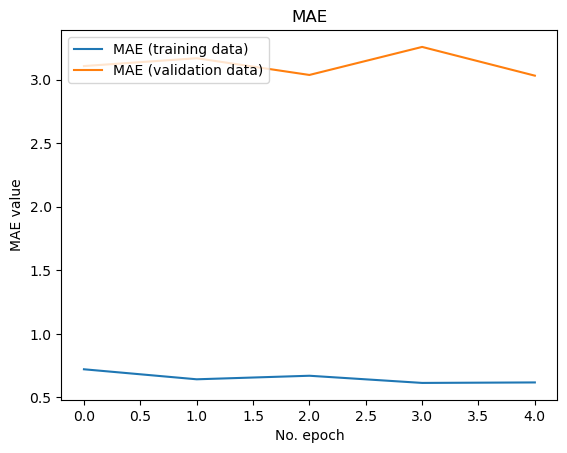

Train Score: 0.60 MSE (0.78 RMSE)
Test Score: 2.09 MSE (1.45 RMSE)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


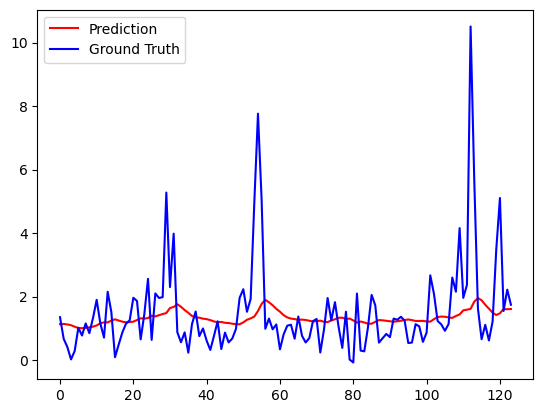

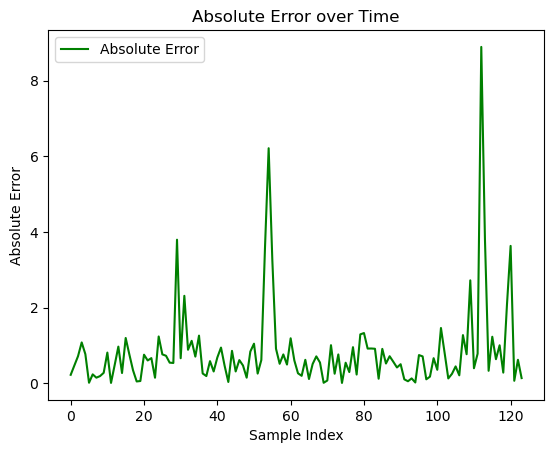

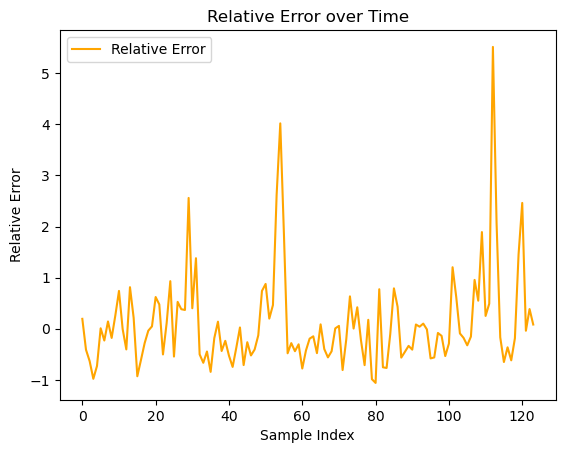

In [30]:
# LSTM (before tuning)

# Plot lstm_history: MAE
plt.plot(lstm_history.history['loss'], label='MAE (training data)')
plt.plot(lstm_history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Evaluate the model
trainScore = lstm_model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = lstm_model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

# Predict and calculate error
pred = lstm_model.predict(X_test)
diff = []
ratio = []

for i in range(len(y_test)):
    ratio.append((y_test[i] / pred[i][0]) - 1)
    diff.append(abs(y_test[i] - pred[i][0]))

# Plot predictions vs actual values
plt.plot(pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

# Plot the errors
plt.plot(diff, color='green', label='Absolute Error')
plt.title('Absolute Error over Time')
plt.xlabel('Sample Index')
plt.ylabel('Absolute Error')
plt.legend(loc='upper left')
plt.show()

# Plot the relative error (ratio)
plt.plot(ratio, color='orange', label='Relative Error')
plt.title('Relative Error over Time')
plt.xlabel('Sample Index')
plt.ylabel('Relative Error')
plt.legend(loc='upper left')
plt.show()

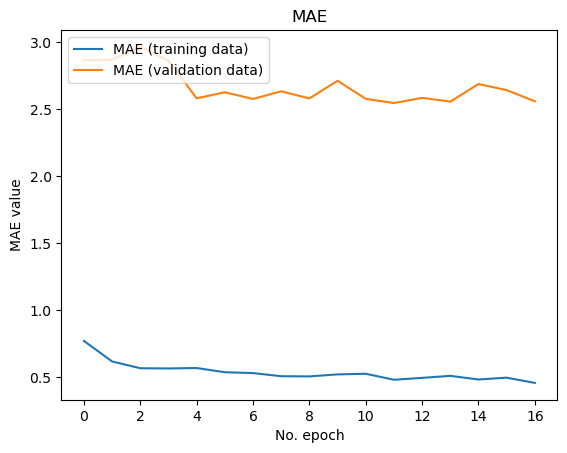

Train Score: 0.53 MSE (0.73 RMSE)
Test Score: 1.95 MSE (1.40 RMSE)
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x35eb582c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


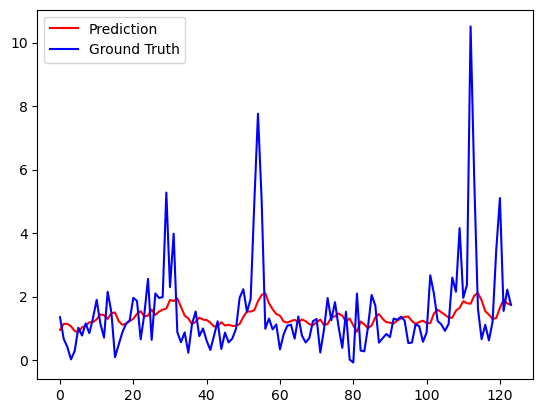

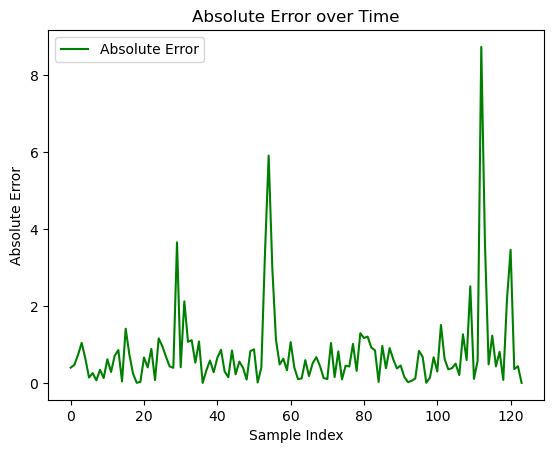

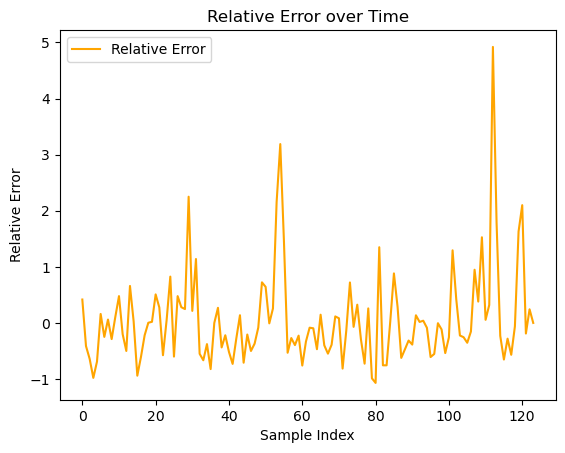

In [31]:
# GRU (before tuning)

# Plot history: MAE
plt.plot(gru_history.history['loss'], label='MAE (training data)')
plt.plot(gru_history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Evaluate the model
trainScore = gru_model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = gru_model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

# Predict and calculate error
pred = gru_model.predict(X_test)
diff = []
ratio = []

for i in range(len(y_test)):
    ratio.append((y_test[i] / pred[i][0]) - 1)
    diff.append(abs(y_test[i] - pred[i][0]))

# Plot predictions vs actual values
plt.plot(pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

# Plot the errors
plt.plot(diff, color='green', label='Absolute Error')
plt.title('Absolute Error over Time')
plt.xlabel('Sample Index')
plt.ylabel('Absolute Error')
plt.legend(loc='upper left')
plt.show()

# Plot the relative error (ratio)
plt.plot(ratio, color='orange', label='Relative Error')
plt.title('Relative Error over Time')
plt.xlabel('Sample Index')
plt.ylabel('Relative Error')
plt.legend(loc='upper left')
plt.show()

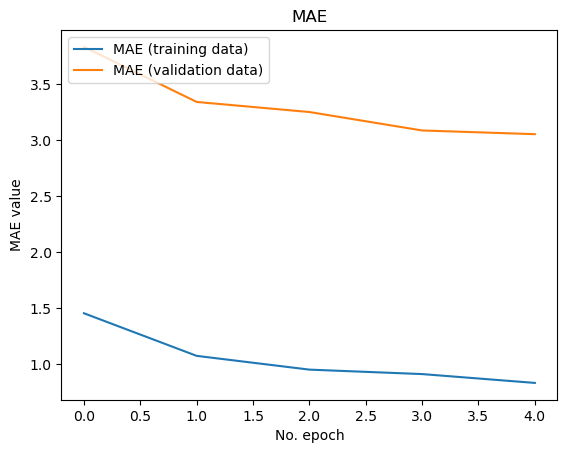

Train Score: 0.50 MSE (0.71 RMSE)
Test Score: 1.98 MSE (1.41 RMSE)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


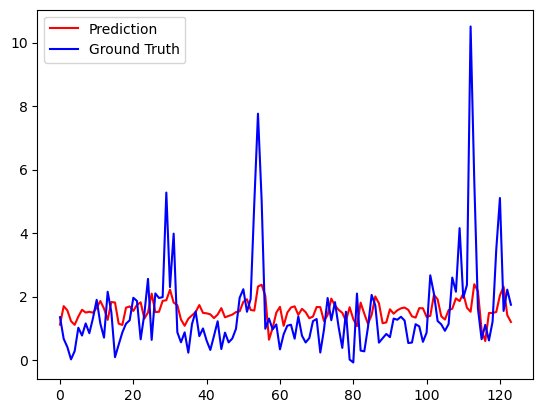

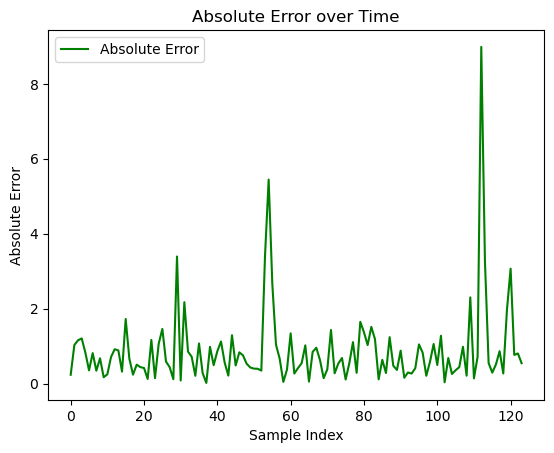

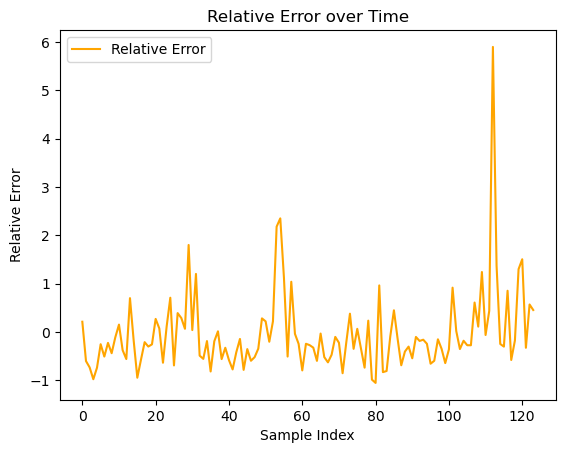

In [32]:
# Vanilla RNN (before tuning)

# Plot history: MAE
plt.plot(vrnn_history.history['loss'], label='MAE (training data)')
plt.plot(vrnn_history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Evaluate the model
trainScore = vrnn_model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = vrnn_model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

# Predict and calculate error
pred = vrnn_model.predict(X_test)
diff = []
ratio = []

for i in range(len(y_test)):
    ratio.append((y_test[i] / pred[i][0]) - 1)
    diff.append(abs(y_test[i] - pred[i][0]))

# Plot predictions vs actual values
plt.plot(pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()

# Plot the errors
plt.plot(diff, color='green', label='Absolute Error')
plt.title('Absolute Error over Time')
plt.xlabel('Sample Index')
plt.ylabel('Absolute Error')
plt.legend(loc='upper left')
plt.show()

# Plot the relative error (ratio)
plt.plot(ratio, color='orange', label='Relative Error')
plt.title('Relative Error over Time')
plt.xlabel('Sample Index')
plt.ylabel('Relative Error')
plt.legend(loc='upper left')
plt.show()

## 5.1 After tuning
Predict and reverse scaling for visualisation

The evaluation of the three models (Vanilla RNN, LSTM and GRU) is given under the section 4.1 Early Stopping and Hyperparameter tuning and is explained in the report

In [33]:
# Reverse scaling for predicted values
pred_rescaled = pred.reshape((pred.shape[0], -1))
y_test_rescaled = y_test.reshape((y_test.shape[0], -1))

# Reshaping
pred_rescaled = pred_rescaled.reshape((pred_rescaled.shape[0], 1))
y_test_rescaled = y_test_rescaled.reshape((y_test_rescaled.shape[0], 1))

y_test_rescaled

array([[ 1.3515408 ],
       [ 0.67126914],
       [ 0.41148995],
       [ 0.0227552 ],
       [ 0.2856479 ],
       [ 1.02015108],
       [ 0.77401468],
       [ 1.15510719],
       [ 0.84777634],
       [ 1.32584026],
       [ 1.89895087],
       [ 1.15306926],
       [ 0.70914064],
       [ 2.15238985],
       [ 1.51248049],
       [ 0.09113901],
       [ 0.48672345],
       [ 0.87002372],
       [ 1.14740835],
       [ 1.25287112],
       [ 1.96342864],
       [ 1.86158886],
       [ 0.65513555],
       [ 1.44953116],
       [ 2.55884324],
       [ 0.63758673],
       [ 2.09996981],
       [ 1.95657894],
       [ 1.98329844],
       [ 5.27675973],
       [ 2.29968675],
       [ 3.98301518],
       [ 0.87721308],
       [ 0.5616173 ],
       [ 0.87409958],
       [ 0.23373735],
       [ 1.13484113],
       [ 1.53087845],
       [ 0.7548808 ],
       [ 0.99688473],
       [ 0.61115027],
       [ 0.31966997],
       [ 0.76382504],
       [ 1.22405708],
       [ 0.34791792],
       [ 0

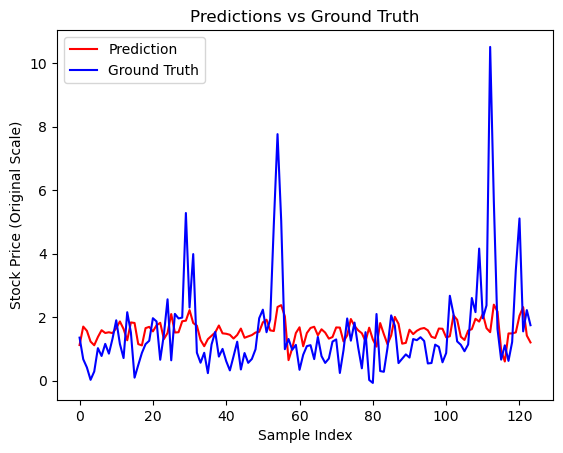

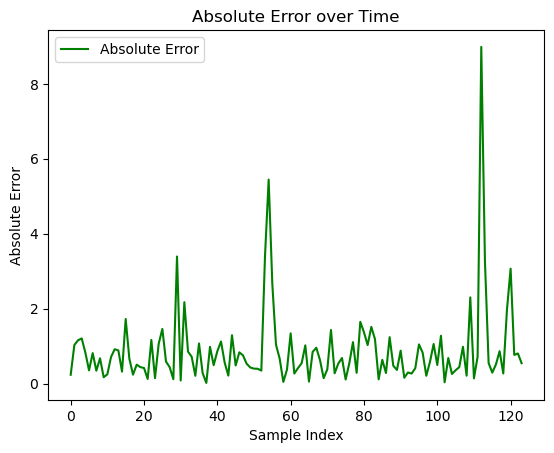

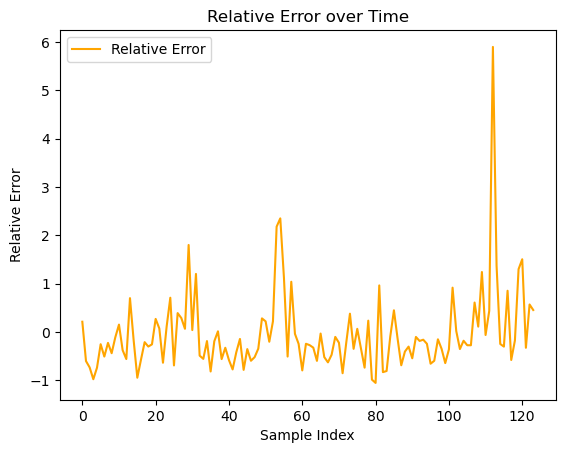

In [34]:
# Models after hyperparameter tuned

# Plot predictions vs actual values
plt.plot(pred_rescaled, color='red', label='Prediction')
plt.plot(y_test_rescaled, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.title('Predictions vs Ground Truth')
plt.xlabel('Sample Index')
plt.ylabel('Stock Price (Original Scale)')
plt.show()

# Calculate errors
diff = []
ratio = []
for i in range(len(y_test_rescaled)):
    ratio.append((y_test_rescaled[i] / pred_rescaled[i]) - 1)
    diff.append(abs(y_test_rescaled[i] - pred_rescaled[i]))

# Plot the errors
plt.plot(diff, color='green', label='Absolute Error')
plt.title('Absolute Error over Time')
plt.xlabel('Sample Index')
plt.ylabel('Absolute Error')
plt.legend(loc='upper left')
plt.show()

# Plot the relative error (ratio)
plt.plot(ratio, color='orange', label='Relative Error')
plt.title('Relative Error over Time')
plt.xlabel('Sample Index')
plt.ylabel('Relative Error')
plt.legend(loc='upper left')
plt.show()


(All the explanations are in the report)

### References

Based on workshop codes